In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import load_model
from keras import layers
import os
import tensorflow as tf
import datetime
from collections import deque
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [4]:

df_all = pd.read_csv('NVDA.csv')
df_all.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
df_all['Date'] = pd.to_datetime(df_all['Date'])
df_all = df_all[['Date', 'Close']]

train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close']]
train_df.index = train_df.pop('Date')

test_df = pd.read_csv('NVDA_test.csv')
test_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df[['Date', 'Close']]
test_df.index = test_df.pop('Date')


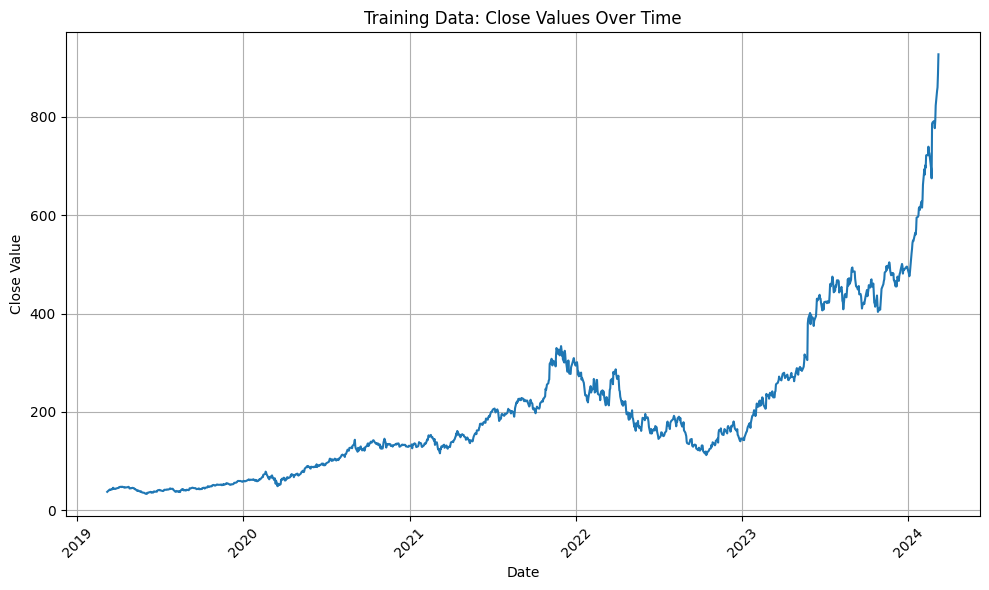

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(df_all['Date'], df_all['Close'], marker='', linestyle='-')
plt.title('Training Data: Close Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# datapreprocessing for lstm

In [6]:
def generate_windowed_dataset(dataframe, start_date_str, end_date_str, col_names, target_col, window_size):
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)

    target_date = start_date
    dates = []
    X, y = [], []

    while True:
        window_data = dataframe.loc[:target_date].tail(window_size + 1)

        if len(window_data) != window_size + 1:
            print(f'Error: Window of size {window_size} is too large for date {target_date}')
            return

        values = window_data[col_names].values
        X.append(values[:-1])

        target_value = window_data[target_col].values[-1]  # Extract the target column value
        y.append(target_value)
        dates.append(target_date)

        next_date = target_date + pd.tseries.offsets.BDay(1)  # Move to the next business day

        if next_date > end_date:
            break

        # Move to the next trading day
        while next_date not in dataframe.index:
            next_date += pd.tseries.offsets.BDay(1)

        target_date = next_date

    ret_df = pd.DataFrame({'Target Date': dates})
    for i, col_name in enumerate(col_names):
        for j in range(window_size):
            ret_df[f'{col_name}-{window_size-j}'] = np.array(X)[:, j, i]
    ret_df[f'Target'] = y

    return ret_df


# # # Example usage:
# windowed_df = generate_windowed_dataset(train_df,
#                                         '2021-08-25',
#                                         '2022-08-31',
#                                         ['Close', 'Volume'],  # Example of multiple features
#                                         'Close',  # Target column
#                                         3)
# print(windowed_df)


In [7]:
def prepare_dataset_for_lstm(windowed_dataframe):
    dates = windowed_dataframe['Target Date'].to_numpy()
    X = windowed_dataframe.iloc[:, 1:-1].to_numpy().reshape(len(windowed_dataframe), -1, 1)
    y = windowed_dataframe['Target'].to_numpy()
    return dates, X.astype(np.float32), y.astype(np.float32)


# w = prepare_dataset_for_lstm(windowed_df)[1]
# w.shape

# LSTM Baseline

## preprocessing

In [6]:
windowed_df = generate_windowed_dataset(train_df, '2023-01-05', '2023-12-29', ['Close'], 'Close', 3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'prepare_dataset_for_lstm' is not defined

## training

In [243]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model.save(os.path.join(save_dir, 'baseline.keras'))

Epoch 1/100
7/7 [==============================] - 2s 50ms/step - loss: 127503.0469 - mean_absolute_error: 341.7372 - val_loss: 217585.1562 - val_mean_absolute_error: 465.5582
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 126805.5391 - mean_absolute_error: 340.7149 - val_loss: 216763.7344 - val_mean_absolute_error: 464.6752
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 126152.7812 - mean_absolute_error: 339.7357 - val_loss: 215586.4219 - val_mean_absolute_error: 463.4067
Epoch 4/100
7/7 [==============================] - 0s 5ms/step - loss: 125205.2500 - mean_absolute_error: 338.3349 - val_loss: 214034.7031 - val_mean_absolute_error: 461.7299
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: 124043.1484 - mean_absolute_error: 336.6375 - val_loss: 212413.8438 - val_mean_absolute_error: 459.9709
Epoch 6/100
7/7 [==============================] - 0s 5ms/step - loss: 122724.6250 - mean_absolute_error: 334.6578 - val_los

## plotting

7/7 [==============================] - 0s 1ms/step


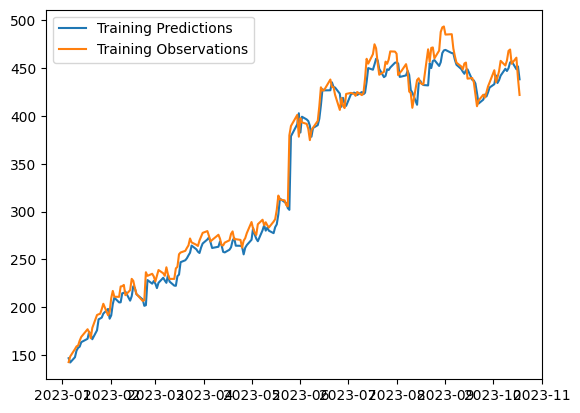

In [244]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 2ms/step


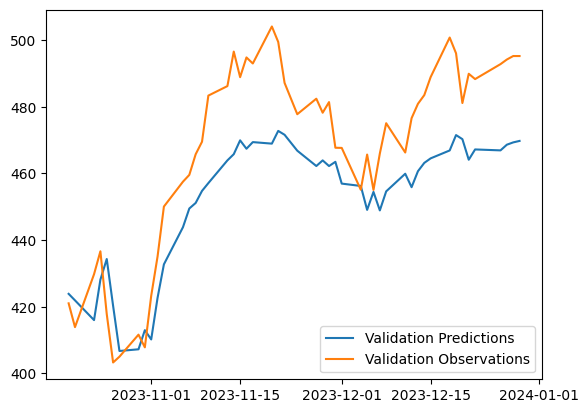

In [245]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

## evaluating on test set

1/1 [==============================] - 0s 412ms/step - loss: 3607.0637 - mean_absolute_error: 58.2565
Test Loss: 3607.063720703125
Test Mean Absolute Error: 58.256526947021484
[481.679993, 475.690002, 479.980011]
deque([481.679993, 475.690002, 479.980011], maxlen=3)
[481.679993, 475.690002, 479.980011]
1/1 [==============================] - 0s 15ms/step


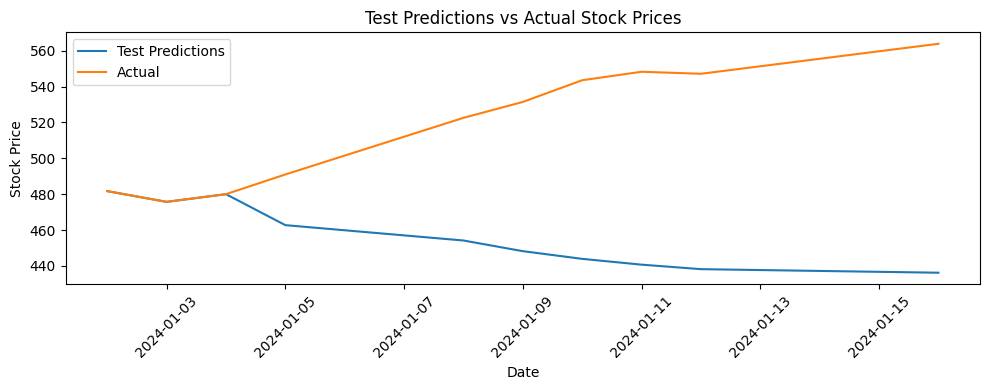

In [249]:
model = load_model('trained_models/baseline.keras')
windowed_test_df = generate_windowed_dataset(test_df, '2024-01-05', '2024-01-15', ['Close'], 'Close', 3)
dates_test, X_test, y_test = prepare_dataset_for_lstm(windowed_test_df)


loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Mean Absolute Error: {mae}')

n = 10
s = 0

values = test_df[['Close']].iloc[s:s+3].to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()

print(values)


measures = deque(values, maxlen=3)
measures_list = list(measures)

print(measures)
print(measures_list)

for date in range(n-3):
    x = np.array(measures, dtype=float).reshape((1,3,1))
    pred_measure = model.predict(x).flatten()[0]
    measures.append(pred_measure)
    values.append(pred_measure)


plt.figure(figsize=(10, 4))
# plt.plot(df_all)
plt.plot(dates, values, label='Test Predictions')
plt.plot(dates, test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist(), label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Z-score scaling

In [150]:
train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close']]
train_df.index = train_df.pop('Date')

test_df = pd.read_csv('NVDA_test.csv')
test_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df[['Date', 'Close']]
test_df.index = test_df.pop('Date')


train_mean = train_df['Close'].mean()
train_std = train_df['Close'].std()

test_mean = test_df['Close'].mean()
test_std = test_df['Close'].std()

# Apply z-score normalization
train_df['Close'] = (train_df['Close'] - train_mean) / train_std
test_df['Close'] = (test_df['Close'] - test_mean) / test_std

## preprocessing

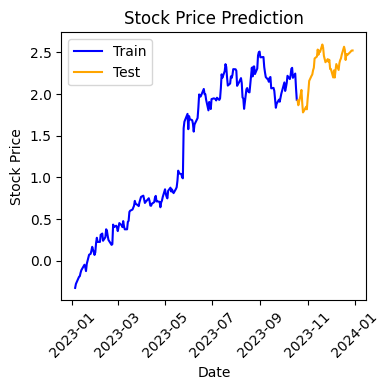

In [151]:
windowed_df = generate_windowed_dataset(train_df, '2023-01-05', '2023-12-29',  ['Close'], 'Close', 3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## training

In [152]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(3, len(['Close']))))
model.add(Dropout(0.3))
model.add(LSTM(120, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Dense(1))

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define a ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, 'zscore_.keras')
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',  # Choose the metric to monitor
                             save_best_only=True,  # Save only the best model
                             mode='min',  # 'min' for validation loss, 'max' for accuracy, 'auto' for automatic
                             verbose=1)

# Train the model with the callback
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=1000,
                    callbacks=[checkpoint], verbose=0)


Epoch 1: val_loss improved from inf to 2.48122, saving model to trained_models\zscore_.keras

Epoch 2: val_loss improved from 2.48122 to 0.05528, saving model to trained_models\zscore_.keras

Epoch 3: val_loss did not improve from 0.05528

Epoch 4: val_loss did not improve from 0.05528

Epoch 5: val_loss did not improve from 0.05528

Epoch 6: val_loss improved from 0.05528 to 0.01349, saving model to trained_models\zscore_.keras

Epoch 7: val_loss did not improve from 0.01349

Epoch 8: val_loss did not improve from 0.01349

Epoch 9: val_loss did not improve from 0.01349

Epoch 10: val_loss did not improve from 0.01349

Epoch 11: val_loss did not improve from 0.01349

Epoch 12: val_loss improved from 0.01349 to 0.01155, saving model to trained_models\zscore_.keras

Epoch 13: val_loss improved from 0.01155 to 0.01119, saving model to trained_models\zscore_.keras

Epoch 14: val_loss did not improve from 0.01119

Epoch 15: val_loss did not improve from 0.01119

Epoch 16: val_loss did not 

OSError: [Errno 22] Invalid argument: 'trained_models\\zscore_.keras'

## plotting

2/2 [==============================] - 0s 2ms/step


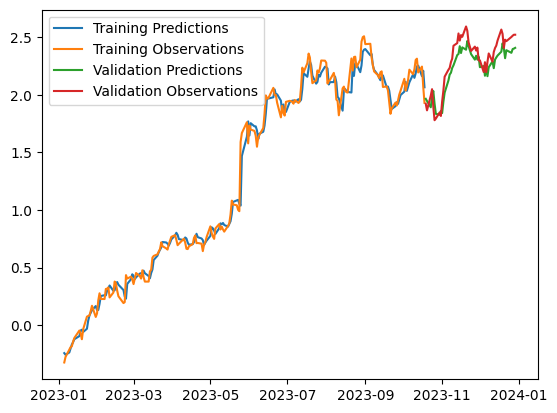

In [258]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions, label='Training Predictions')
plt.plot(dates_train, y_train, label='Training Observations')
plt.legend()

val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.legend()

plt.show()


## evaluating on test set

1/1 [==============================] - 1s 726ms/step - loss: 281012.5938 - mean_absolute_error: 529.6573
Test Loss: 281012.59375
Test Mean Absolute Error: 529.6573486328125
1/1 [==============================] - 0s 14ms/step


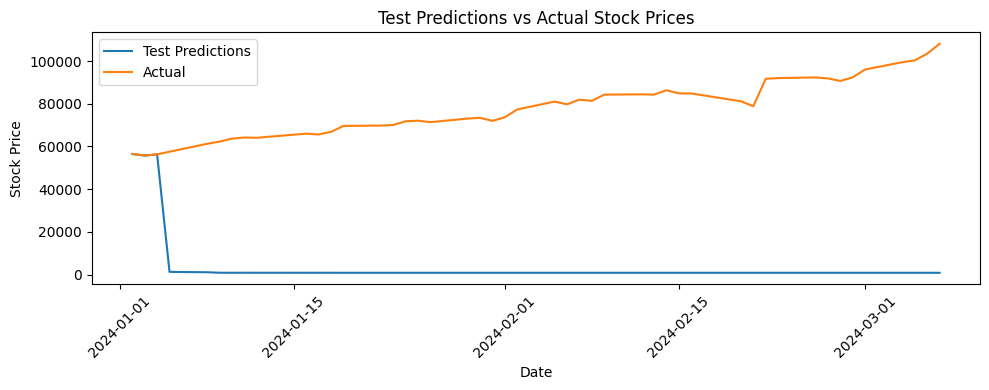

In [190]:
model = load_model('trained_models/zscore.keras')
windowed_test_df = generate_windowed_dataset(test_df, '2024-01-05', '2024-01-15', ['Close'], 'Close', 3)
dates_test, X_test, y_test = prepare_dataset_for_lstm(windowed_test_df)

loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Mean Absolute Error: {mae}')

n = 46
s = 0

values = test_df[['Close']].iloc[s:s+3].to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()
measures = deque(values, maxlen=3)
measures_list = list(measures)

for date in range(n-3):
    x = np.array(measures, dtype=float).reshape((1,3,1))
    pred_measure = model.predict(x).flatten()[0]
    measures.append(pred_measure)
    values.append(pred_measure)

values = [(val * test_std) + test_mean for val in values]
actual_values = test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist()
actual_values = [(val * test_std) + test_mean for val in actual_values]

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(dates, values, label='Test Predictions')
plt.plot(dates, actual_values, label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Returns 

In [8]:
train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close']]
train_df.index = train_df.pop('Date')

df_ret_train = train_df.copy()
df_ret_train['Return'] = df_ret_train['Close'].pct_change()
df_ret_train.drop(columns=['Close'], inplace=True)
df_ret_train.dropna(inplace=True)

test_df = pd.read_csv('NVDA_test.csv')
test_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df[['Date', 'Close']]
test_df.index = test_df.pop('Date')


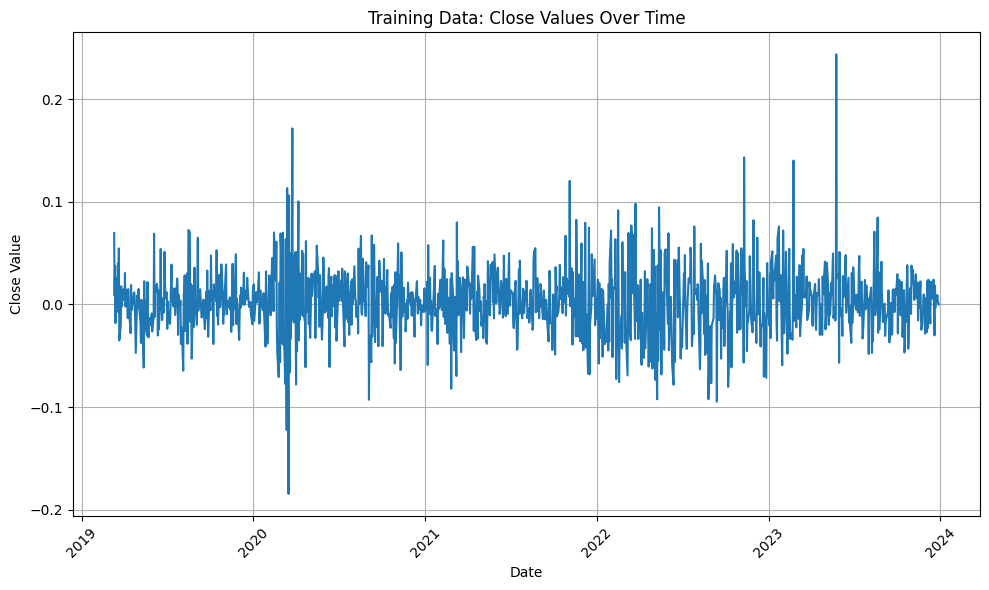

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(df_ret_train.index, df_ret_train['Return'], marker='', linestyle='-')
plt.title('Training Data: Close Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


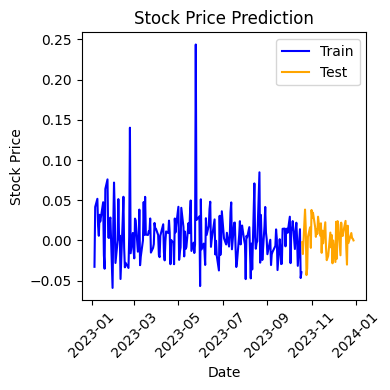

In [10]:
windowed_df = generate_windowed_dataset(df_ret_train, '2023-01-05', '2023-12-29', ['Return'], 'Return', 3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Training

In [30]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(3, len(['Close']))))
model.add(LSTM(80, return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(120, return_sequences=False))
model.add(Dense(20))
model.add(Dense(20))
model.add(Dense(1))

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.01),
              metrics=['mean_absolute_error'])


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define a ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, 'return.keras')
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='loss',  # Choose the metric to monitor
                             save_best_only=True,  # Save only the best model
                             mode='min',  # 'min' for validation loss, 'max' for accuracy, 'auto' for automatic
                             verbose=0)

# Train the model with the callback
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=1000,
                    callbacks=[checkpoint], verbose=1)


Epoch 1/1000
7/7 [==============================] - 5s 148ms/step - loss: 0.0157 - mean_absolute_error: 0.0960 - val_loss: 5.4026e-04 - val_mean_absolute_error: 0.0198
Epoch 2/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0033 - mean_absolute_error: 0.0455 - val_loss: 7.9690e-04 - val_mean_absolute_error: 0.0224
Epoch 3/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0012 - mean_absolute_error: 0.0245 - val_loss: 4.4100e-04 - val_mean_absolute_error: 0.0164
Epoch 4/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0011 - mean_absolute_error: 0.0232 - val_loss: 3.8049e-04 - val_mean_absolute_error: 0.0158
Epoch 5/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0011 - mean_absolute_error: 0.0227 - val_loss: 3.9005e-04 - val_mean_absolute_error: 0.0164
Epoch 6/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0230 - val_loss: 5.1673e-04 - val_mean_absolute_error: 0.017

7/7 [==============================] - 1s 2ms/step


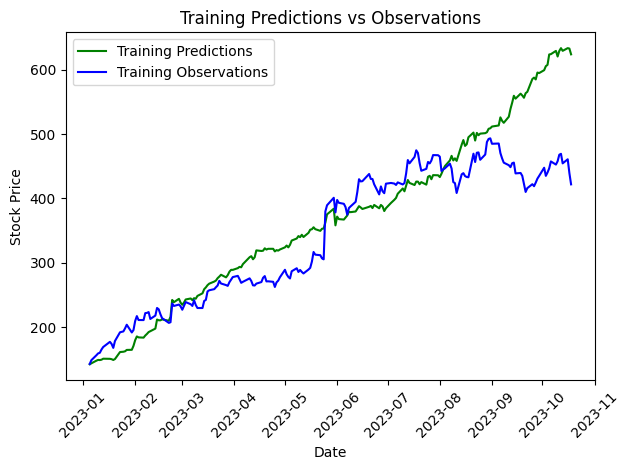

In [31]:
# Load the best model
return_model = load_model('trained_models/return.keras')

first_date = dates_train[0]
first_price = train_df.loc[first_date, 'Close']

train_predictions_pct_change = return_model.predict(X_train).flatten()
train_predictions = np.cumprod(1 + train_predictions_pct_change) * first_price


plt.plot(dates_train, train_predictions, color='green')

# Plot the real observations for the training dates
real_observations = [train_df.loc[date, 'Close'] for date in dates_train]
plt.plot(dates_train, real_observations, color='blue')

# Plot the predictions in the original price space
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Training Predictions vs Observations')
plt.legend(['Training Predictions', 'Training Observations'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2/2 [==============================] - 0s 4ms/step


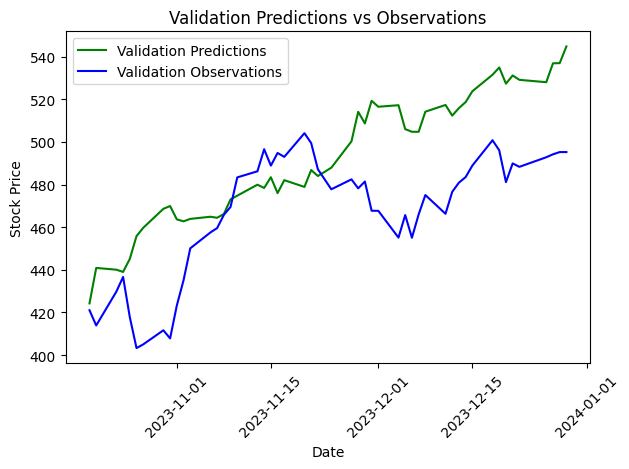

In [32]:
first_date_val = dates_val[0]
first_price_val = train_df.loc[first_date_val, 'Close']

# Obtain predictions for the validation set
val_predictions_pct_change = return_model.predict(X_val).flatten()
val_predictions = np.cumprod(1 + val_predictions_pct_change) * first_price_val


# Plot the validation predictions and observations
plt.plot(dates_val, val_predictions, color='green')

# Plot the real observations for the validation dates
real_observations_val = [train_df.loc[date, 'Close'] for date in dates_val]
plt.plot(dates_val, real_observations_val, color='blue')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Validation Predictions vs Observations')
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

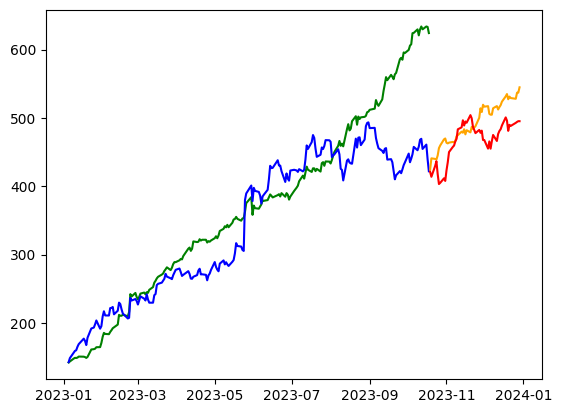

In [33]:
plt.plot(dates_train, train_predictions, color='green')
plt.plot(dates_train, real_observations, color='blue')

# Plot the validation predictions and observations
plt.plot(dates_val, val_predictions, color='orange')
plt.plot(dates_val, real_observations_val, color='red')

1/1 [==============================] - 1s 1s/step - loss: 287064.9688 - mean_absolute_error: 535.3403
Test Loss: 287064.96875
Test Mean Absolute Error: 535.3402709960938
1/1 [==============================] - 1s 767ms/step
0.010716681
1/1 [==============================] - 0s 14ms/step
-0.0047444645
1/1 [==============================] - 0s 14ms/step
0.002534632
1/1 [==============================] - 0s 14ms/step
0.01910837
1/1 [==============================] - 0s 15ms/step
0.008884624
1/1 [==============================] - 0s 14ms/step
-0.0061642528
1/1 [==============================] - 0s 15ms/step
0.0032375338


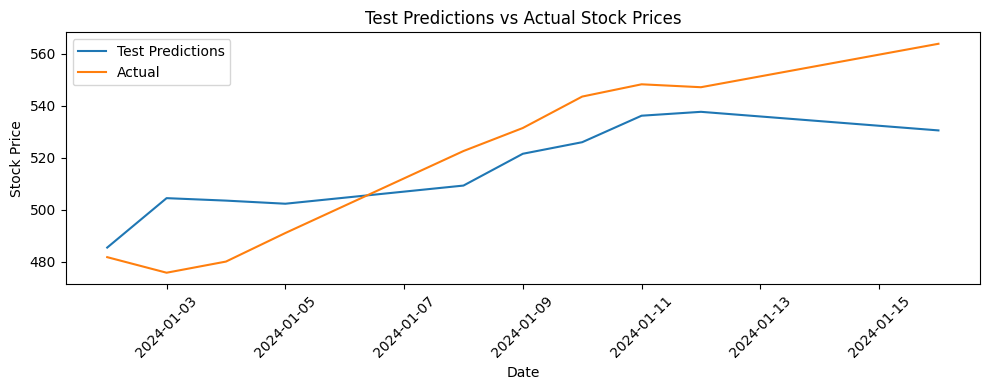

In [34]:
from keras.models import load_model
from keras.optimizers import Adam


model = load_model('trained_models/return.keras')

windowed_test_df = generate_windowed_dataset(test_df, '2024-01-06', '2024-01-15', ['Close'], 'Close', 3)
dates_test, X_test, y_test = prepare_dataset_for_lstm(windowed_test_df)

loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Mean Absolute Error: {mae}')

n = 10
s = 0

return_values_pct_change = test_df[['Close']].iloc[s:s+4].pct_change().dropna().to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()

last_3_returns = deque(return_values_pct_change, maxlen=3)

for date in range(n-3):
    x = np.array(last_3_returns, dtype=float).reshape((1,3,1))
    test_predictions_pct_change = model.predict(x).flatten()[0]
    print(test_predictions_pct_change)
    last_3_returns.append(test_predictions_pct_change)
    return_values_pct_change.append(test_predictions_pct_change)

first_test_value = test_df[['Close']].iloc[s, 0]
test_predictions = np.cumprod(1 + val_predictions_pct_change) * first_test_value
test_predictions = test_predictions[s:s+n]

actual_values = test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist()


# Calculate evaluation metrics
# mae_test = mean_absolute_error(actual_values[3:], test_predictions)
# mse_test = mean_squared_error(actual_values[3:], test_predictions)
# rmse_test = np.sqrt(mse_test)

# print(f'Test MAE: {mae_test}')
# print(f'Test MSE: {mse_test}')
# print(f'Test RMSE: {rmse_test}')

plt.figure(figsize=(10, 4))
# plt.plot(df)
plt.plot(dates, test_predictions, label='Test Predictions')
plt.plot(dates, actual_values, label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# News

In [7]:
import pandas as pd

file_path = 'news_retrieval/labelled_newscatcher_dataset.csv'

# Load the data and select specific columns
df = pd.read_csv(file_path, sep=';')

# Convert 'published_date' to datetime format
df['published_date'] = pd.to_datetime(df['published_date'])

# Select specific columns
df = df[['published_date', 'title']]

# Filter rows containing the word 'AI' in the 'title' column
df['contains_AI'] = df['title'].str.contains('AI', case=True)

# Create a new DataFrame with counts of AI articles published each day
daily_AI_counts = df.groupby(df['published_date'].dt.date)['contains_AI'].sum().reset_index()
daily_AI_counts.columns = ['published_date', 'AI_articles_count']

# Sort the new DataFrame by 'published_date'
daily_AI_counts = daily_AI_counts.sort_values(by='published_date')

print(daily_AI_counts)


    published_date  AI_articles_count
0       2012-09-16                  0
1       2015-10-23                  0
2       2016-09-23                  0
3       2016-12-08                  0
4       2016-12-22                  0
..             ...                ...
258     2020-08-14                 16
259     2020-08-15                 17
260     2020-08-16                  6
261     2020-08-17                 32
262     2020-08-18                  3

[263 rows x 2 columns]


# Multivariate LSTM

## data preprocessing

In [214]:
train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close', 'Volume']]
train_df.index = train_df.pop('Date')

test_df = pd.read_csv('NVDA_test.csv')
test_df.drop(columns=['Open', 'High', 'Low', 'Adj Close'], inplace=True)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df[['Date', 'Close', 'Volume']]
test_df.index = test_df.pop('Date')


# train_means = train_df.mean()
# train_stds = train_df.std()

# test_means = test_df.mean()
# test_stds = test_df.std()

# for col in train_df.columns:
#     train_df[col] = (train_df[col] - train_means[col]) / train_stds[col]
#     test_df[col] = (test_df[col] - test_means[col]) / test_stds[col]


# feature_list = train_df.columns.to_list()
# n_features = len(feature_list)
# window_size = 3

# print(feature_list)
# print(train_df.head())
# print(test_df.head())

            Predicted_Volume
2023-12-29      4.884346e+07
2024-01-01      4.885145e+07
2024-01-02      4.885943e+07
2024-01-03      4.886742e+07
2024-01-04      4.887540e+07
2024-01-05      4.888338e+07
2024-01-08      4.889137e+07
2024-01-09      4.889935e+07
2024-01-10      4.890734e+07
2024-01-11      4.891532e+07
2024-01-12      4.892331e+07
2024-01-15      4.893129e+07
2024-01-16      4.893928e+07
2024-01-17      4.894726e+07
2024-01-18      4.895524e+07
2024-01-19      4.896323e+07
2024-01-22      4.897121e+07
2024-01-23      4.897920e+07
2024-01-24      4.898718e+07
2024-01-25      4.899517e+07
2024-01-26      4.900315e+07
2024-01-29      4.901114e+07
2024-01-30      4.901912e+07
2024-01-31      4.902710e+07
2024-02-01      4.903509e+07
2024-02-02      4.904307e+07
2024-02-05      4.905106e+07
2024-02-06      4.905904e+07
2024-02-07      4.906703e+07
2024-02-08      4.907501e+07
2024-02-09      4.908300e+07
2024-02-12      4.909098e+07
2024-02-13      4.909897e+07
2024-02-14    

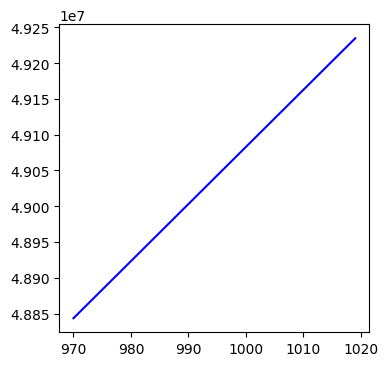

In [215]:
# Read the data and preprocess
train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close', 'Volume']]
train_df.index = train_df.pop('Date')

def predict_future_values(train_df, feature_columns, future_days):
    future_df = pd.DataFrame(index=pd.bdate_range(start=train_df.index[-1], periods=future_days))

    for feature_column in feature_columns:
        split = int(len(train_df) * 0.8)
        train_data = train_df.iloc[:split]

        X_train = np.arange(len(train_data)).reshape(-1, 1)
        y_train = train_data[feature_column].values

        model = LinearRegression()
        model.fit(X_train, y_train)

        X_future = np.arange(len(train_data), len(train_data) + future_days).reshape(-1, 1)
        y_future_pred = model.predict(X_future)

        future_df[f'Predicted_{feature_column}'] = y_future_pred

        plt.figure(figsize=(4, 4))
        plt.plot(X_future, y_future_pred, label='Train', color='blue')

    return future_df

future_features = ['Volume']
future_days = 50
future_df = predict_future_values(train_df, future_features, future_days)
print(future_df)


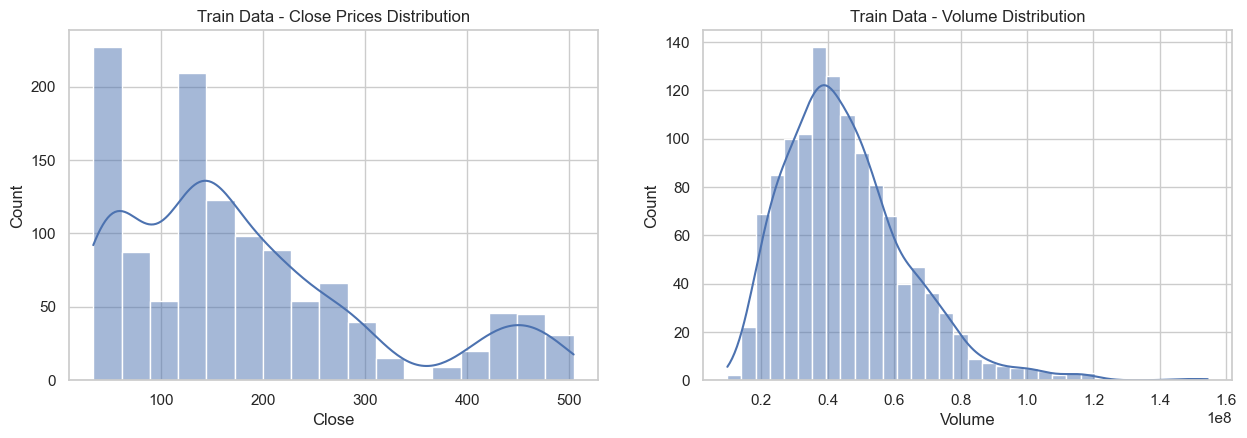

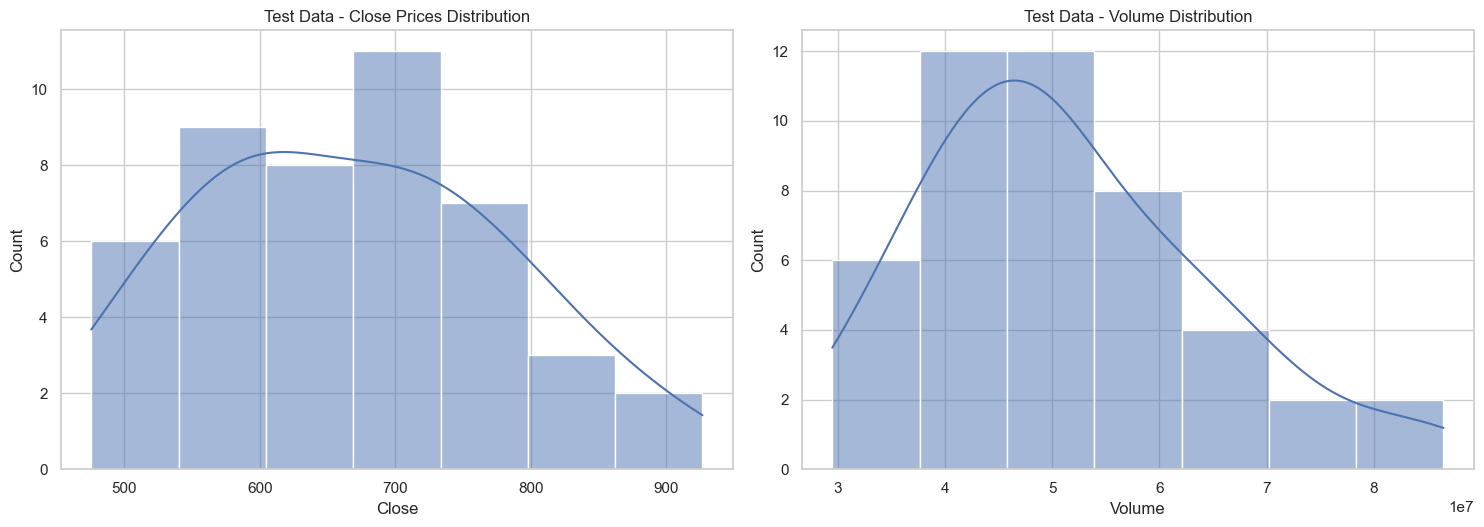

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns


# Set the style of seaborn for better aesthetics
sns.set_theme(style="whitegrid")

# Plotting for train_df
plt.figure(figsize=(15, 10))

# Plot Close prices distribution
plt.subplot(2, 2, 1)
sns.histplot(train_df['Close'], kde=True)
plt.title('Train Data - Close Prices Distribution')

# Plot Volume distribution
plt.subplot(2, 2, 2)
sns.histplot(train_df['Volume'], kde=True)
plt.title('Train Data - Volume Distribution')

# Plotting for test_df
plt.figure(figsize=(15, 10))

# Plot Close prices distribution
plt.subplot(2, 2, 3)
sns.histplot(test_df['Close'], kde=True)
plt.title('Test Data - Close Prices Distribution')

# Plot Volume distribution
plt.subplot(2, 2, 4)
sns.histplot(test_df['Volume'], kde=True)
plt.title('Test Data - Volume Distribution')

plt.tight_layout()
plt.show()


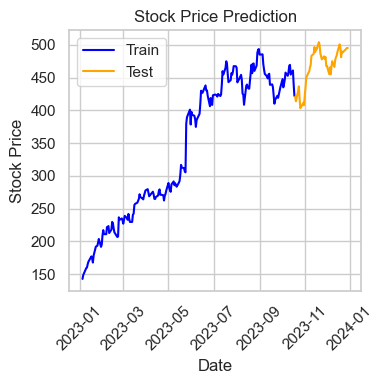

In [217]:
feature_list = ['Close', 'Volume']

windowed_df = generate_windowed_dataset(train_df, '2023-01-05', '2023-12-29', feature_list, 'Close', window_size=3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## training

In [39]:
n_features = 2

model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(3*n_features, len(['Close']))))
model.add(Dropout(0.3))
model.add(LSTM(120, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Dense(1))

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define a ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, 'multivariate.keras')
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',  # Choose the metric to monitor
                             save_best_only=True,  # Save only the best model
                             mode='min',  # 'min' for validation loss, 'max' for accuracy, 'auto' for automatic
                             verbose=1)

# Train the model with the callback
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    callbacks=[checkpoint], verbose=0)

ValueError: in user code:

    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 6, 1), found shape=(None, 3, 1)


## plotting

2/2 [==============================] - 0s 3ms/step


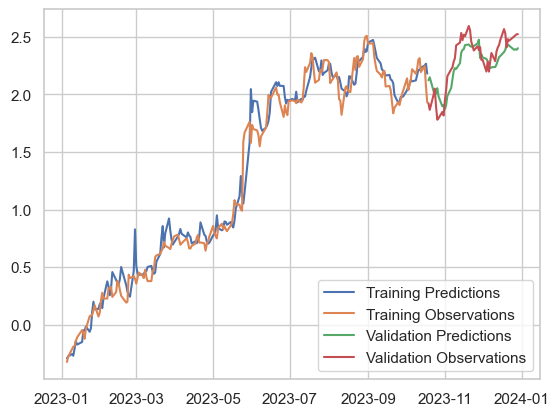

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions, label='Training Predictions')
plt.plot(dates_train, y_train, label='Training Observations')
plt.legend()

val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.legend()

plt.show()


## evaluating on test set

In [16]:
print(feature_list)

['Close', 'Volume']


In [241]:
model = load_model('trained_models/multivariate.keras')
windowed_test_df = generate_windowed_dataset(test_df, '2024-01-05', '2024-01-15', feature_list, 'Close', 3)
dates_test, X_test, y_test = prepare_dataset_for_lstm(windowed_test_df)

print(X_test)

loss, mae = model.evaluate(X_test, y_test)
# print(f'Test Loss: {loss}')
# print(f'Test Mean Absolute Error: {mae}')

n = 4
s = 0

values = test_df['Close'].iloc[s:s+3].to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()
measures = deque(values, maxlen=3)
measures_list = list(measures)


pred_measure = model.predict(X_test).flatten()[0]
measures.append(pred_measure)
values.append(pred_measure)


print("values", values)

for date in range(n-3):
    x = np.array(measures, dtype=float).reshape((1,n_features*3,1))
    print(x)
    pred_measure = model.predict(x).flatten()[0]
    print(pred_measure)
    measures.append(pred_measure)
    values.append(pred_measure)

values = [(val * test_std) + test_mean for val in values]
actual_values = test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist()
actual_values = [(val * test_std) + test_mean for val in actual_values]

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(dates, values, label='Test Predictions')
plt.plot(dates, actual_values, label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

KeyError: "['Volume'] not in index"

In [ ]:
# Ensemble

In [146]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, average

# Load your models
baseline = load_model('trained_models/baseline.keras')
returns = load_model('trained_models/return.keras')

models = [baseline, returns]

# Define the input layers for each model
baseline_input = Input(shape=baseline.input_shape[1:])
returns_input = Input(shape=returns.input_shape[1:])

# List of input layers
model_inputs = [baseline_input, returns_input]

# Connect each input layer to its corresponding model
baseline_output = baseline(baseline_input)
returns_output = returns(returns_input)

# Collect outputs of models in a list
yModels = [baseline_output, returns_output]

# Averaging outputs
yAvg = average(yModels)

# Build model from the list of input layers and the averaged output
modelEns = Model(inputs=model_inputs, outputs=yAvg, name='ensemble')

# modelEns.summary()

# Assuming x_baseline and x_returns are the input data for baseline and returns models
pred = modelEns.predict([X_train, X_train])
print(pred)


7/7 [==============================] - 1s 2ms/step
[[3.4754126]
 [3.3046417]
 [3.5129724]
 [3.6541708]
 [3.5719292]
 [3.4695294]
 [3.5358298]
 [3.542585 ]
 [3.6354258]
 [3.412767 ]
 [3.2420564]
 [3.5749507]
 [3.788876 ]
 [3.5678196]
 [3.445062 ]
 [3.4961278]
 [3.5484545]
 [3.2196715]
 [3.3781123]
 [3.6838536]
 [3.670804 ]
 [3.3779972]
 [3.3568478]
 [3.580833 ]
 [3.4865844]
 [3.4411674]
 [3.2121594]
 [3.4066083]
 [3.6272676]
 [3.461979 ]
 [3.2686489]
 [3.21633  ]
 [3.1887732]
 [3.335368 ]
 [3.9439006]
 [3.575806 ]
 [3.465426 ]
 [3.3512373]
 [3.2853599]
 [3.4532738]
 [3.5259526]
 [3.3914092]
 [3.3330553]
 [3.516435 ]
 [3.3311682]
 [3.2753725]
 [3.3402472]
 [3.5710905]
 [3.501874 ]
 [3.6403544]
 [3.5176525]
 [3.4559171]
 [3.451855 ]
 [3.4549372]
 [3.5225677]
 [3.383739 ]
 [3.3404443]
 [3.3488662]
 [3.4644656]
 [3.4854078]
 [3.4839888]
 [3.4498398]
 [3.3370452]
 [3.2790594]
 [3.3679721]
 [3.4705074]
 [3.3699472]
 [3.2759285]
 [3.3347535]
 [3.4208288]
 [3.445887 ]
 [3.509696 ]
 [3.4761298]


# Comments

In [ ]:
# Very bad extrapolation (learn data outside its range), for it to better extrapolate we can train it on a smaller interval closer the dates we actually want to predict
# In most models its good to minmax scale, but not in the case of stock market predictions because there is no maximum value prices are always increasing
